# Recurrent Neural Networks
All the models we have discussed so far were looking at the inputs as isolated instances. In image classification we determine the category of and image, in semantic segmentation we produce a semantic map from the input. But there are many cases were datapoints are not isolated instances and have connection to each other. Sequential data are the type of data where each instance is related to the instances came before. A good example for this type of data is time series data. At each point in time to the value of the time series depends on the value of the prior points. Recurrent Neural Networks (RNN) are a class of networks which deal with sequential data. There are many variants of Recurrent Neural Networks, including:
- Simple Recurrect Neural Networks (Simple RNN - or often just called RNN)
- Long Short-Term Memory (LSTM)
- Gated Recurrent Unit (GRU)

In this notebook we will discuss LSTM; however, the general logic behind all these methods are the same. They only differ in the way they handel information internally. 
<img src='./images/RNN.PNG'>
<div style="font-size:70%">Recurrent Neural Networks Architecture - Credit to <a href='https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0180944'>Bao et al.</a></div>
At each step a set of values are stored as state of the model ($s$). The state is updated at each step and based on the value of the state the output of the model is calculated by passing state through the output layer ($V$). Also, the model takes an input $x_t$ and passes it through an input layer ($U$), The output of this layer is combined with the state of previous step and creates the new state ($s_t$). What is important here is that the input and output layers are the same for all the sequences of data. What makes the output different at each step are the input values and state of the model. <br>
Various architectures handel updating the state value differently and this is the main difference between Simple RNN, LSTM, and GRU. 

## Single Variate Time Series
 Recurrent Neural Networks can be quite useful for time series forecasting due to their ability to understand sequential nature of data. For the start we can see how an LSTM can forcast a time series with only one variable.

### Predicting Sine Function
In the first example we will use an LSTM model to predict the value of sine function. Since the sine function is easy to calculate we can easily evaluate the performance of the model. 

In [229]:
import torch
from torch import nn, optim
from torch import functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

<IPython.core.display.Javascript object>

Let's create some data for training:

In [230]:
t = np.linspace(0, 100, 1000)
sine = np.sin(t)

<IPython.core.display.Javascript object>

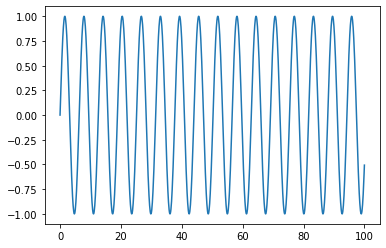

In [47]:
plt.plot(t,sine)

#### Creating the model
In an LSTM the model takes one data point at the time and produces an output. This output is also called the hidden state. We can use the hidden state to calculate the next value in the sequence. The hidden state helps the model to remember what happened before and not just look at each point as an isolated instance. <br>
Pytorch LSTM component can needs a few inputs:
- __input_size:__ The size of the input data. In this example since we are dealing with a single variate data we pass in one value at a time, therefore, the input size is one.
- __hidden_size:__ This represents how many values should be stored as the hidden state in the model. Larger values allows model to understand more complex patterns in the data.
- __num_layers:__ This value refers to the number of layers in the LSTM block. Similar to what we saw in tabular data, having multiple layers allows the model to work with more complex patterns.

When we are creating our model we add a linear layer as well which will be our output layer. The output layer converts the hidden state to output value. Depending on what we want the output to be we can choose the size of output as well. In this example, we are trying to find the next value in the series, therefore, the model only returns a single value.

In [231]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        _, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.linear(h_out)

        return out

<IPython.core.display.Javascript object>

#### Preparing Data
The data for an LSTM model is a bit different from what we have seen so far. Since this model is supposed to look at a few data points to predict the next one, data needs to be broken down to smaller sections. At each step we pass a few data points into the model and the model will forecast the next. The longer this sequence of input is the better the model will be, however, this also means we require larger memory and longer training time.<br>
The function below will create the inputs and targets for the model.


In [232]:
def create_seq_data(series,seq_length):
    sequence = []
    target = []
    for i in range(len(series)-1-seq_length):
        sequence.append(series[i:i+seq_length])
        target.append(series[i+1])
    return np.array(sequence), np.array(target)


<IPython.core.display.Javascript object>

Let's split the data into a training and test set. Note that here `x` contains sets of 5 consecutive numbers and `y` contains the respective number that comes after each serie.

In [233]:
seq_length = 5
x, y = create_seq_data(sine, seq_length)

xtrain = x[:600, :]
ytrain = y[:600]

xtest = x[600:, :]
ytest = y[600:]

<IPython.core.display.Javascript object>

Let's print xtrain to better understand what it contains.

In [234]:
print(xtrain)

[[ 0.          0.09993302  0.19886554  0.29580708  0.3897871 ]
 [ 0.09993302  0.19886554  0.29580708  0.3897871   0.47986471]
 [ 0.19886554  0.29580708  0.3897871   0.47986471  0.56513807]
 ...
 [-0.06944341 -0.16878755 -0.26644185 -0.36142863 -0.4527969 ]
 [-0.16878755 -0.26644185 -0.36142863 -0.4527969  -0.53963192]
 [-0.26644185 -0.36142863 -0.4527969  -0.53963192 -0.62106432]]


<IPython.core.display.Javascript object>

Now we can create an instance of the model with input size of one (single variate series), one layer LSTM with hidden state size of 50.

In [235]:
model = LSTM(input_size=1, hidden_size=50, num_layers=1)


<IPython.core.display.Javascript object>

Also we need to choose the optimiser, and loss function. Let's use mean square error loss and ADAM optimiser.

In [ ]:
loss_func = torch.nn.MSELoss(reduction="mean")  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#### Training the model
Now that all the components are ready we can train the model.

In [236]:
epochs = 500
model.train()
for epoch in tqdm(range(epochs)):
    input_values = torch.Tensor(xtrain).unsqueeze(-1)
    optimizer.zero_grad()
    preds = model(input_values)
    loss = loss_func(preds, torch.Tensor(ytrain).unsqueeze(-1))
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"#{epoch} Loss = {loss.item():.5f}")

#0 Loss = 0.49104
#50 Loss = 0.00599
#100 Loss = 0.00311
#150 Loss = 0.00282
#200 Loss = 0.00254
#250 Loss = 0.00226
#300 Loss = 0.00199
#350 Loss = 0.00171
#400 Loss = 0.00143
#450 Loss = 0.00115



<IPython.core.display.Javascript object>

Note that when using `xtrain` and `ytrain` we first converted them to tensors, then used `unsqueeze(-1)`. `unsqueeze(-1)` adds a dimension to the end of the tensor. Why did we do that? The reason is to specify that the model is dealing with only one value.

In [240]:
print("Normal shape:")
print(torch.Tensor(xtrain).shape)
print("\nUnsqueezed(-1) shape")
print(torch.Tensor(xtrain).unsqueeze(-1).shape)

Normal shape:
torch.Size([600, 5])

Unsqueezed(-1) shape
torch.Size([600, 5, 1])


<IPython.core.display.Javascript object>

Prior to unsqueezing the shape is the number of datapoints by the length of sequences. But after unsqueezing we have `1` as the last dimension which specifies that we are passing in one value. When we unsqueeze `y` we are specifying that the output is one value.

#### Forecasting
Now let's look at the results and see how good the model is at forecasting.

In [241]:
model_input = torch.Tensor(xtest).unsqueeze(-1)
pred_test = model(model_input)

<IPython.core.display.Javascript object>

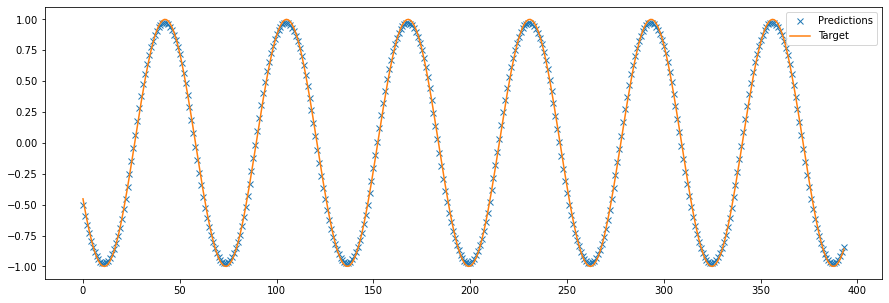

<IPython.core.display.Javascript object>

In [242]:
plt.figure(figsize=(15, 5))
plt.plot(pred_test.detach().numpy(), "x", label="Predictions")
plt.plot(ytest, label="Target")
plt.legend()

### Predicting Customers
Let's start working with a real time series data with seasonality and trend. Unlike traditional techniques we don't need to tell the model about the trend and seasonality. LSTM will be able to recognise the patterns on its own.

#### Preparing Data

In [111]:
import pandas as pd

In [112]:
df = pd.read_csv('./Customers.csv')

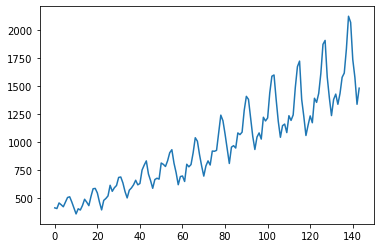

In [114]:
df['Customers'].plot()

To prepare the data for the model it is highly recommended to normalise the data. There are different ways to do that. You can use standard scaling or min-max scaling, etc. The advantage of normalisation is that the model doesn't need to deal with extremely large or extremely small values, which makes it more likely the model is able to forecast based on the pattern. Here, we will use `MinMaxScaler` from Scikit Learn package.

In [187]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(df[['Customers']])



((131, 12, 1), (131, 1))

Now we need to decide how many values to use for predicting. Here we are going to use 12, since we know data is monthly and has annual seasonality. Therefore seeing the past 12 months allows the model the see a full perioid. We can also choose larger or smaller values and see how it would affect the results.

In [ ]:
seq_length = 12
x, y = create_seq_data(data,seq_length)
x.shape, y.shape

Note that the shape of `x` and `y` are now suitable for the model and we won't need to unsqueeze them anymore.

In [188]:
xtrain = x[:100,:,:]
ytrain = y[:100,:]
xtest = x[100:,:,:]
ytest = y[100:,:]

#### Training model
We are going to use the same class as the last example so we only need to create a new instance of the same model.

In [243]:
model = LSTM(1, 50, 1)
loss_func = torch.nn.MSELoss(reduction="mean")  # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

<IPython.core.display.Javascript object>

In [206]:
def train_model(model, x, y, epochs = 1):
    model.train()
    for epoch in tqdm(range(epochs)):
        input_values = torch.Tensor(x)
        optimizer.zero_grad()
        preds = model(input_values)
        loss = loss_func(preds , torch.Tensor(y))
        loss.backward()
        optimizer.step()
        if (epoch+1)%50 == 0:
            print(f'#{epoch+1} Loss = {loss.item():.5f}')


In [207]:
train_model(model, xtrain, ytrain, 500)

#50 Loss = 0.00509
#100 Loss = 0.00262
#150 Loss = 0.00146
#200 Loss = 0.00093
#250 Loss = 0.00101
#300 Loss = 0.00083
#350 Loss = 0.00084
#400 Loss = 0.00164
#450 Loss = 0.00072
#500 Loss = 0.00060



#### Results
Let's check out how model performs when forecasting.

In [208]:
def test_model(model,x,y):
    model.eval()
    model_input = torch.Tensor(x)
    pred_test = model(model_input)
    plt.figure(figsize=(15,5))
    plt.plot(pred_test.detach().numpy(),':x',label = 'Predictions')
    plt.plot(y,label = 'Target')
    plt.legend()

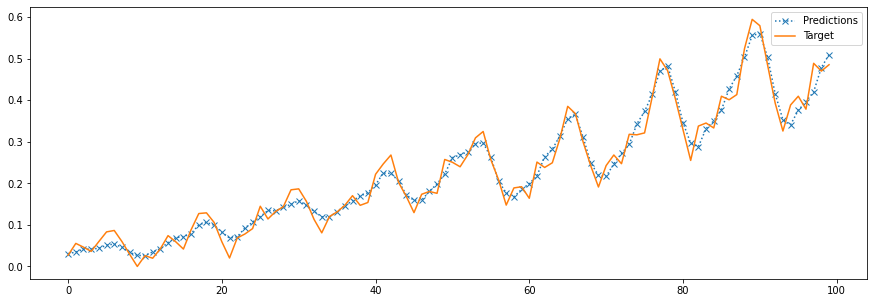

In [209]:
test_model(model, xtrain, ytrain)

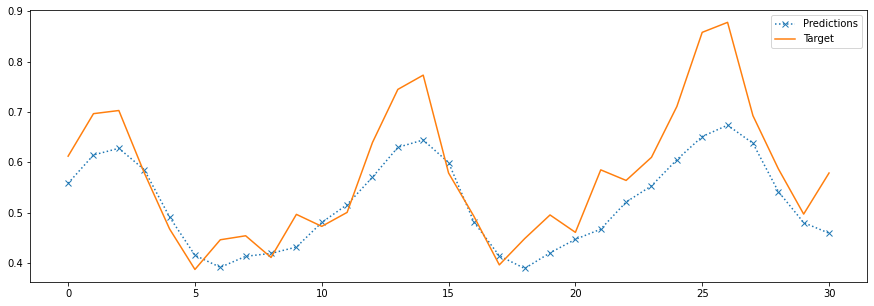

In [210]:
test_model(model, xtest, ytest)

The predictions are not too bad but can certainly be improved. In most cases the model seems to underestimate the values. There are a number of techniques we can use to improve the results. One would be removing the trend from the data. By removing the trend the remaining values will be oscillating around zero and the pattern is much easier for the model to predict.<br>
Another way to improve the model is by changing the size of the model. This can be very effective as it allows the model to handle more complex patterns.

#### Exercise
As an exercise try to improve the performance of the model:
1. Increase the sequence length from 12 to 18
2. Increase the hidden size of the model from 50 to 100

## Multivariate Time Series
Now that we know how to train a model using LSTM let's start working on more difficult problems. In multivariate time series, as the name suggests, we have to deal with multiple values at a time. We need to find out how these values affect each other and forecast the next step. There are many variations to this problem. In this example we will try to forecast the value of a set of variables in the next time step. The goal is to forecast Temperature, Pressure, Relative Humidity, Wind Speed, and Dew Point, using their previous and current values.

#### Preparing Data

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('./energydata_complete.csv')

In [4]:
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


Select the columns we need.

In [7]:
data = df[['T_out','Press_mm_hg','RH_out','Windspeed','Tdewpoint']]

This time we will use standard scaling to normalise the data.

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

normalised = scaler.fit_transform(data)


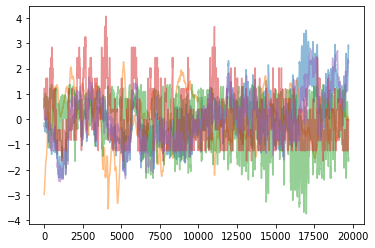

In [17]:
plt.plot(normalised, alpha = .5);

Similar to single variate time series, we need to create data in a form that each instance of data has the values for the past few time steps.

In [18]:
def create_multi_seq_data(series,seq_length):
    sequence = []
    target = []
    for i in range(len(series)-1-seq_length):
        sequence.append(series[i:i+seq_length,:])
        target.append(series[i+1,:])
    return np.array(sequence), np.array(target)

Let's use 2 hours history for prediction. Therefore, the sequence length would be 12 (data points are recorded every 10 minutes).

In [28]:
seq_length = 12
x,y=create_multi_seq_data(normalised,seq_length)

 # We take 90% of data for training and the rest for testing
cutoff = int(len(x)*.9)

xtrain = x[:cutoff,:,:]
ytrain = y[:cutoff,:]

xtest = x[cutoff:,:,:]
ytest = y[cutoff:,:]

#### Training model
We can still use the same class of model. We only need to set the size of input and output.

In [62]:
model = LSTM(5,100,1,5)
loss_func= torch.nn.MSELoss(reduction = 'mean')    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [244]:
def train_model(model, x, y, epochs=1):
    model.train()
    for epoch in tqdm(range(epochs)):
        input_values = torch.Tensor(x)
        optimizer.zero_grad()
        preds = model(input_values)
        loss = loss_func(preds, torch.Tensor(y))
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 20 == 0:
            print(f"#{epoch+1} Loss = {loss.item():.5f}", end="\r", flush=True)

<IPython.core.display.Javascript object>

In [64]:
train_model(model,xtrain,ytrain,100)

#1 Loss = 0.97494
#2 Loss = 0.79091
#3 Loss = 0.58084
#4 Loss = 0.34507
#5 Loss = 0.30938
#6 Loss = 0.24193
#7 Loss = 0.18396
#8 Loss = 0.16132
#9 Loss = 0.14873
#10 Loss = 0.13992
#11 Loss = 0.13988
#12 Loss = 0.13857
#13 Loss = 0.12881
#14 Loss = 0.11490
#15 Loss = 0.10250
#16 Loss = 0.09395
#17 Loss = 0.08980
#18 Loss = 0.08957
#19 Loss = 0.09083
#20 Loss = 0.09057
#21 Loss = 0.08718
#22 Loss = 0.08103
#23 Loss = 0.07425
#24 Loss = 0.06947
#25 Loss = 0.06790
#26 Loss = 0.06862
#27 Loss = 0.06899
#28 Loss = 0.06694
#29 Loss = 0.06334
#30 Loss = 0.06031
#31 Loss = 0.05861
#32 Loss = 0.05751
#33 Loss = 0.05612
#34 Loss = 0.05423
#35 Loss = 0.05233
#36 Loss = 0.05079
#37 Loss = 0.04932
#38 Loss = 0.04737
#39 Loss = 0.04527
#40 Loss = 0.04382
#41 Loss = 0.04265
#42 Loss = 0.04123
#43 Loss = 0.03943
#44 Loss = 0.03775
#45 Loss = 0.03607
#46 Loss = 0.03437
#47 Loss = 0.03281
#48 Loss = 0.03158
#49 Loss = 0.03134
#50 Loss = 0.03916
#51 Loss = 0.07899
#52 Loss = 0.03142
#53 Loss = 0.06234
#5

Note that in the examples so far we didn't print the loss value for the test set. Generally, it is recommended to uses loss value of test set to check if the model is overfitting or not.

#### Results
If the loss is low enough we can print the results and see how the model is doing in terms of forecasting.

In [65]:
def test_model(model,x,y,plot_results = False):
    model.eval()
    model_input = torch.Tensor(x)
    pred_test = model(model_input).detach().numpy()
    mse = ((pred_test-y)**2).mean()
    print(f'MSE = {mse:.5f}')
    if plot_results:
        plt.figure(figsize=(15,5))
        plt.plot(pred_test,':x',label = 'Predictions')
        plt.plot(y,label = 'Target')
        plt.legend()
    return pred_test

MSE = 0.01189


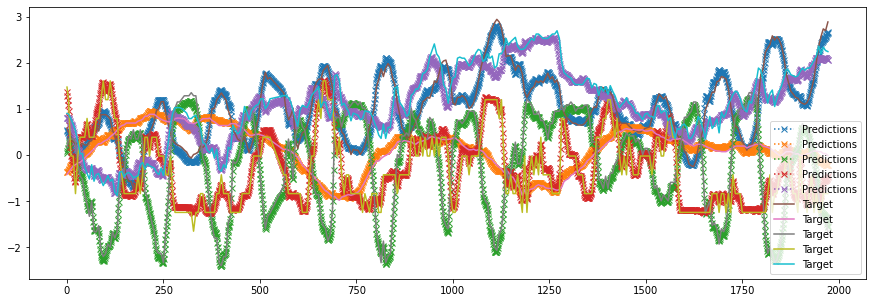

In [66]:
preds = test_model(model,xtest,ytest,True)

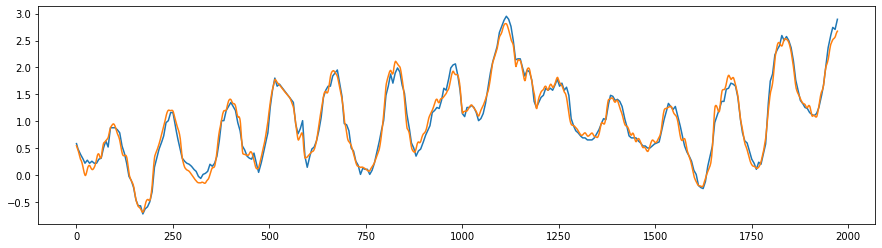

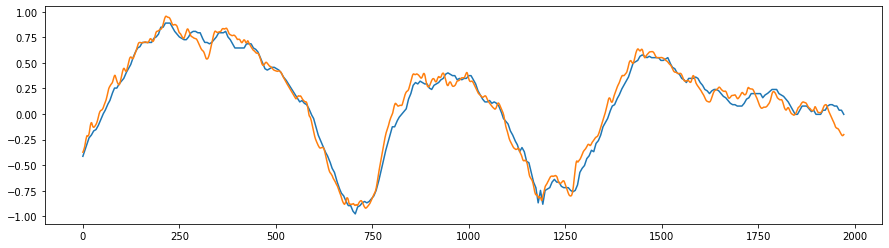

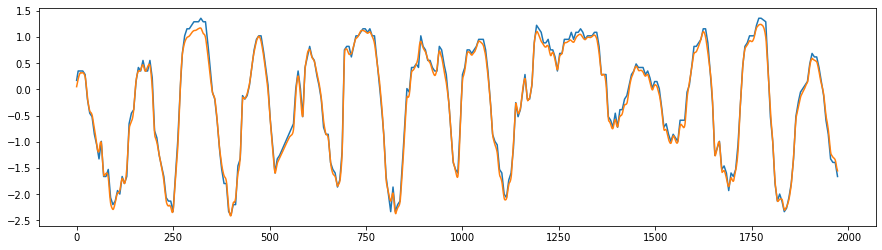

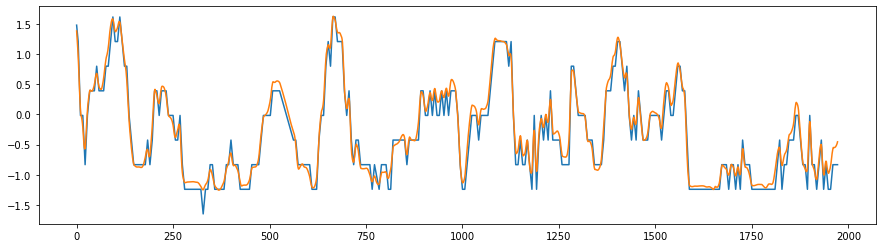

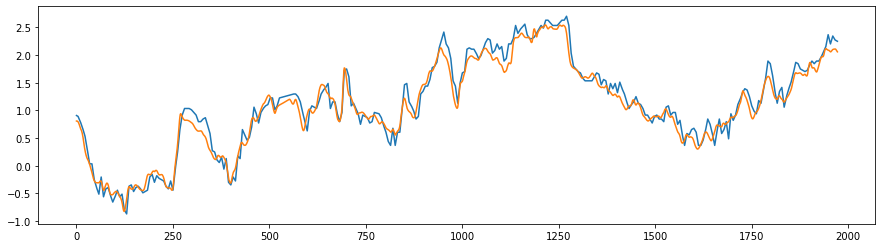

In [70]:
for i in range(5):
    plt.figure(figsize=(15,4))
    plt.plot(ytest[:,i],label = 'Target')
    plt.plot(preds[:,i],label = 'Prediction')
    plt.legend()

## Classification
So far we tried single and multivariate time series using LSTM. But LSTMs are very flexible and useful for wide range of problems. For instance, we can have multi input and single output, or use a series to predict an entire different series. We can also use LSTM for classification of time series. What makes LSTM (or other types of Recurrecnt Neural Networks) interesting is that they are not just useful for time series. They can be used for any data that has sequence of values. For instance, they can be used for text prediction. If we map every word to a number then you can turn a text into a series of numbers then LSTM can be used for predicting the next word.


In this example we are going to look at well logs which are sequential data as well.

In [245]:
import pandas as pd

df = pd.read_parquet(
    "../../data/processed/geolink_norge_dataset/geolink_norge_well_logs_train.parquet"
).set_index(["Well", "DEPT"])
df.head()

LITHOLOGY_GEOLINK       CALI   RHOB         GR  \
Well    DEPT                                                         
15_9-12 2215.917725        Shaly Silt  14.438001  2.363  60.285748   
        2216.070068        Shaly Silt  14.633000  2.340  63.250000   
        2216.222412        Shaly Silt  14.813001  2.314  61.405998   
        2216.375000        Shaly Silt  14.383001  2.293  62.561596   
        2216.527344        Shaly Silt  14.202999  2.275  61.691055   

                            DTC      RDEP      RMED  
Well    DEPT                                         
15_9-12 2215.917725  134.253601  0.737006  0.785088  
        2216.070068  129.101868  0.741000  0.840000  
        2216.222412  122.476944  0.752000  0.858000  
        2216.375000  116.908607  0.739962  0.857046  
        2216.527344  115.390953  0.715966  0.886082

<IPython.core.display.Javascript object>

We will be using depth and other measurements to determine the lithology. We dealt with the same problem in the tablular data. But in tabular data we only look at the measurements at each depth to find the class, while here we can look at the variations in the measurements as well.

Let's get a list of wells:

In [9]:
wells = np.unique(np.array([w for w, d in df.index]))


<IPython.core.display.Javascript object>

And add depth as a feature column:

In [10]:
depths = np.array([d for w, d in df.index])
df["Depths"] = depths

<IPython.core.display.Javascript object>

As usual we need to create a training and test set. here we will only use `15` wells for training and `15` for testing as using the entire dataset means we need to spend much longer time for training.

In [21]:
np.random.seed(12)
n_wells = 15
selected_wells = np.random.choice(wells, n_wells * 2, replace=False)
training_wells = selected_wells[:n_wells]
test_wells = selected_wells[n_wells:]

<IPython.core.display.Javascript object>

We need to process the input and target data. The input data needs to be normalised with a standard scaler, and the output data needs to be converted from text to numbers. To convert text to numbers we use `LabelEncoder` from Scikit Learn.

In [33]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

scaler = StandardScaler()
encoder = LabelEncoder()
encoder.fit(df["LITHOLOGY_GEOLINK"])

feat_cols = ["CALI", "RHOB", "GR", "DTC", "RDEP", "RMED", "Depths"]
scaler.fit(df[feat_cols].values)

StandardScaler()

<IPython.core.display.Javascript object>

`LabelEncoder` converts each type to a value.

In [35]:
encoder.transform(["Shaly Silt"])

array([17], dtype=int64)

<IPython.core.display.Javascript object>

Now we can check the types at various depths:

In [ ]:
plt.figure(figsize=(16, 5))
idx = 0
x = df.loc[wells[idx], "Depths"]
y = encoder.transform(df.loc[wells[idx], "LITHOLOGY_GEOLINK"])
plt.plot(x, y)

The output of a classification model is a value for each type. The type with the highest value is the one the model thinks is most likely to be associated with the input data. Therefore, the output size of the model should be the number of types.

In [25]:
output_size = len(df["LITHOLOGY_GEOLINK"].unique())

<IPython.core.display.Javascript object>

Let's create training and test set, similar to what we had in multivariate time series. The only difference is here for each sequence of values we want the model to predict a value for each type.

In [105]:
seq_length = 10

x_train = []
y_train = []
for well in tqdm(training_wells):
    features = scaler.transform(df.loc[well,feat_cols].values)
    targets = encoder.transform(df.loc[well,'LITHOLOGY_GEOLINK'])
    for i in range(len(targets)-seq_length):
        xi = features[i:i+seq_length,:]
        yi = targets[i+seq_length-1]
        x_train.append(xi)
        y_train.append(yi)

x_test = []
y_test = []
for well in tqdm(test_wells):
    features = scaler.transform(df.loc[well,feat_cols].values)
    targets = encoder.transform(df.loc[well,'LITHOLOGY_GEOLINK'])
    for i in range(len(targets)-seq_length):
        xi = features[i:i+seq_length,:]
        yi = targets[i+seq_length-1]
        x_test.append(xi)
        y_test.append(yi)        


<IPython.core.display.Javascript object>

It is important that we make sure the training and test set have close distribution. For instance, if there is a certain type in test data that doesn't exist in training data, the model will not be able to predict it.

In [118]:
def show_distribution(y):
    plt.hist(y, output_size * 2)
    plt.xticks(np.arange(output_size))

<IPython.core.display.Javascript object>

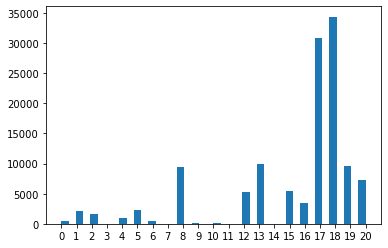

<IPython.core.display.Javascript object>

In [119]:
show_distribution(y_train)

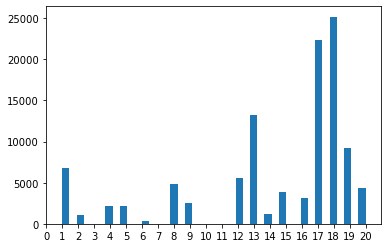

<IPython.core.display.Javascript object>

In [120]:
show_distribution(y_test)

In [121]:
device = "cpu"
x_train = torch.Tensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.Tensor(x_test).to(device)
y_test = torch.LongTensor(y_test).to(device)

<IPython.core.display.Javascript object>

We can still use the same class for the model. Here the input size is the number of features we are using to predict the type, and output size is the number of types. 

In [205]:
model = LSTM(
    input_size=len(feat_cols),
    hidden_size=200,
    num_layers=1,
    output_size=output_size,
)
model = model.to(device)

<IPython.core.display.Javascript object>

In [206]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = torch.nn.CrossEntropyLoss()

<IPython.core.display.Javascript object>

In [208]:
from sklearn.metrics import accuracy_score

<IPython.core.display.Javascript object>

In [217]:
def training_loop(epochs=1, bs=128):
    pbar1 = tqdm(total=epochs)
    pbar2 = tqdm(total=len(x_train) // bs)
    all_losses = []
    all_accuracies = []
    for epoch in range(epochs):
        model.train()
        training_loss = []
        training_accuracy = []
        pbar2.reset(len(x_train) // bs)
        for i in range(0, len(x_train), bs):
            optimizer.zero_grad()
            preds = model(x_train[i : i + bs, ...])
            loss = loss_func(preds, y_train[i : i + bs])
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())
            accuracy = accuracy_score(
                y_train[i : i + bs].numpy(), preds.detach().numpy().argmax(-1)
            )
            training_accuracy.append(accuracy)
            pbar2.update(1)
            print(
                f"Epoch {epoch+1}/{epochs}: Loss = {loss.item():.2f}, Accuracy = {accuracy:.3f}",
                end="\r",
                flush=True,
            )

        print(
            f"Epoch {epoch+1}/{epochs}: Training Loss = {np.mean(training_loss):.2f}, Accuracy = {np.mean(accuracy):.3f}"
        )

        model.eval()
        test_loss = []
        test_accuracy = []
        pbar2.reset(len(x_test) // bs)
        for i in range(0, len(x_test), bs):
            preds = model(x_test[i : i + bs, ...])
            loss = loss_func(preds, y_test[i : i + bs])
            test_loss.append(loss.item())
            accuracy = accuracy_score(
                y_test[i : i + bs].numpy(), preds.detach().numpy().argmax(-1)
            )
            test_accuracy.append(accuracy)
            pbar2.update(1)
        print(
            f"Epoch {epoch+1}/{epochs}: Test Loss = {np.mean(test_loss):.2f}, Accuracy = {np.mean(test_accuracy):.3f}"
        )
        print("-" * 50)
        all_losses.append([np.mean(training_loss), np.mean(test_loss)])
        all_accuracies.append([np.mean(training_accuracy), np.mean(test_accuracy)])
        pbar1.update(1)

    # Visualising the results
    all_losses = np.array(all_losses)
    plt.plot(all_losses[:, 0], label="Training")
    plt.plot(all_losses[:, 1], label="Test")
    plt.title("Loss")
    plt.legend()
    plt.figure()
    all_accuracies = np.array(all_accuracies)
    plt.plot(all_accuracies[:, 0], label="Training")
    plt.plot(all_accuracies[:, 1], label="Test")
    plt.title("Accuracy")
    plt.legend()

<IPython.core.display.Javascript object>

Let's train for 10 epochs

Epoch 1/10: Training Loss = 1.44, Accuracy = 0.517
Epoch 1/10: Test Loss = 1.96, Accuracy = 0.365
--------------------------------------------------
Epoch 2/10: Training Loss = 1.45, Accuracy = 0.422
Epoch 2/10: Test Loss = 2.03, Accuracy = 0.340
--------------------------------------------------
Epoch 3/10: Training Loss = 1.44, Accuracy = 0.558
Epoch 3/10: Test Loss = 2.02, Accuracy = 0.368
--------------------------------------------------
Epoch 4/10: Training Loss = 1.38, Accuracy = 0.585
Epoch 4/10: Test Loss = 1.97, Accuracy = 0.368
--------------------------------------------------
Epoch 5/10: Training Loss = 1.37, Accuracy = 0.551
Epoch 5/10: Test Loss = 2.06, Accuracy = 0.357
--------------------------------------------------
Epoch 6/10: Training Loss = 1.32, Accuracy = 0.544
Epoch 6/10: Test Loss = 2.06, Accuracy = 0.370
--------------------------------------------------
Epoch 7/10: Training Loss = 1.34, Accuracy = 0.592
Epoch 7/10: Test Loss = 2.07, Accuracy = 0.364
--------

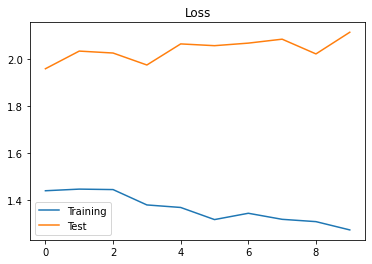

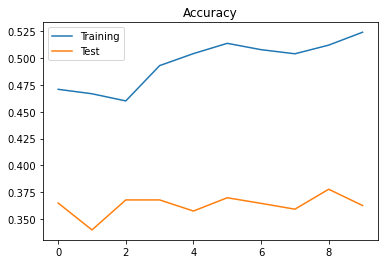

<IPython.core.display.Javascript object>

In [218]:
training_loop(10, 1024)

As we saw in the previous examples the model requires training over 100s of epochs to reach the best results. However, in this example due to large size of dataset and the model we stopped after `10` epochs. Try increasing the number of epochs to see how it will affect the accuracy.<br>

Obviously the model right now is not performing well. But there are number ways we can improve it:
1. Training for longer. instead of stopping after `10` epochs go for longer.
2. Increase the hidden state size.
3. Increase the size of training data by adding data from more wells to training. 
4. Increase the size of the sequences so the model get to look further in the history.

#### Exercise
Try one of the options above to improve the model.

Let's have a look at model's predictions.

In [220]:
preds = model(x_test).argmax(axis=-1).detach().numpy()

<IPython.core.display.Javascript object>

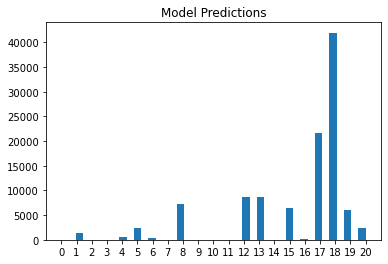

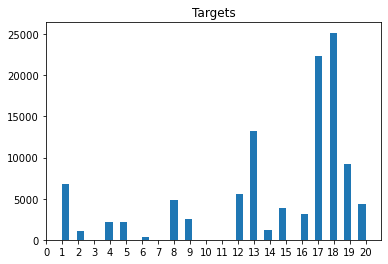

<IPython.core.display.Javascript object>

In [228]:
plt.hist(preds, bins=output_size * 2)
plt.title("Model Predictions")
plt.xticks(np.arange(output_size))
plt.figure()
plt.hist(y_test, bins=output_size * 2)
plt.title("Targets")
plt.xticks(np.arange(output_size));

The distribution of data shows that the model is too focused on type `17` and `18` which is why we are having low accuracy.

## Further Reading
- [Introduction to RNN](http://slazebni.cs.illinois.edu/spring17/lec02_rnn.pdf)
- [A friendly introduction to Recurrent Neural Networks](https://www.youtube.com/watch?v=UNmqTiOnRfg)
- [Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM)](https://www.youtube.com/watch?v=WCUNPb-5EYI&t=97s)
- [Introduction to LSTM](https://medium.com/x8-the-ai-community/a-7-minute-introduction-to-lstm-5e1480e6f52a)
- [LSTM and GRU](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)
- [Time Series Prediction with LSTM](https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/)
- [Building RNN from scratch](https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79)
